# 1. Импорт модулей.

In [2]:
from google.colab import drive
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import *
from tensorflow.keras.models import Sequential, Model
import numpy as np
import pandas as pd
import os
import tensorflow.keras.backend as K
from sklearn.metrics import *
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.preprocessing import MinMaxScaler
import pickle
import seaborn as sns
from matplotlib import pyplot as plt 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


# 2. Перенесение датасета в рабочую область.


Для этого, в основном, будут использоваться инструменты pandas dataframe. А также библиотек sklearn и seaborn.

===========================================================

Dataset Analysis
Main tool is pandas dataframe, sklearn and seaborn as instrument for nice heatmap.

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#Загрузка датасета по частям с дальнейшей конкатенацией. 
df1=pd.read_csv("/content/drive/MyDrive/CICIDS2017/data_analysis/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")#,nrows = 50000
df2=pd.read_csv("/content/drive/MyDrive/CICIDS2017/data_analysis/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv")
df3=pd.read_csv("/content/drive/MyDrive/CICIDS2017/data_analysis/Friday-WorkingHours-Morning.pcap_ISCX.csv")
df4=pd.read_csv("/content/drive/MyDrive/CICIDS2017/data_analysis/Monday-WorkingHours.pcap_ISCX.csv")
df5=pd.read_csv("/content/drive/MyDrive/CICIDS2017/data_analysis/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv")
df6=pd.read_csv("/content/drive/MyDrive/CICIDS2017/data_analysis/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv")
df7=pd.read_csv("/content/drive/MyDrive/CICIDS2017/data_analysis/Tuesday-WorkingHours.pcap_ISCX.csv")
df8=pd.read_csv("/content/drive/MyDrive/CICIDS2017/data_analysis/Wednesday-workingHours.pcap_ISCX.csv")

#Вывод уникальных признаков типов аттак или benign для каждого датасета. Ожидается DDoS, DoS Types и т.д.
print (df1[' Label'].unique())
print (df2[' Label'].unique())
print (df3[' Label'].unique())
print (df4[' Label'].unique())
print (df5[' Label'].unique())
print (df6[' Label'].unique())
print (df7[' Label'].unique())
print (df8[' Label'].unique(), "\n")

#Конкатенация и общая информация о наборе данных
df = pd.concat([df1,df2])
del df1,df2
df = pd.concat([df,df3])
del df3
df= pd.concat([df,df4])
del df4
df = pd.concat([df,df5])
del df5
df = pd.concat([df,df6])
del df6
df = pd.concat([df,df7])
del df7
df = pd.concat([df,df8])
del df8
data = df.copy() #Датафрейм копируем в дату для дальнейших операций
data.info()



['BENIGN' 'DDoS']
['BENIGN' 'PortScan']
['BENIGN' 'Bot']
['BENIGN']
['BENIGN' 'Infiltration']
['BENIGN' 'Web Attack � Brute Force' 'Web Attack � XSS'
 'Web Attack � Sql Injection']
['BENIGN' 'FTP-Patator' 'SSH-Patator']
['BENIGN' 'DoS slowloris' 'DoS Slowhttptest' 'DoS Hulk' 'DoS GoldenEye'
 'Heartbleed'] 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2830743 entries, 0 to 692702
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Len

# 3. Необязательный шаг.



Тепловая карта для сырого датасета. Благодаря ней можно понять основные недостатки сырого датасета и с ними работать в дальнейшем препроцессинге.

In [ ]:
#fig= plt.figure(figsize=(70,70))
#sns.heatmap(data.corr(), annot=True)

# 4. Необходимо отбросить пустые значения из изначального датасета.


Подтягиваем из датасета колонки с NaN и создаем из них массив deleteCol. Получившийся массив "вычитаем" из дата.

In [ ]:
deleteCol = []
for column in data.columns:
    if data[column].isnull().values.any():
        deleteCol.append(column)
for column in deleteCol:
    data.drop([column],axis=1,inplace=True)


Аналогично поступаем с элементами numpy.object

In [ ]:
deleteCol = []
for column in data.columns:
    if column == ' Label':
        continue
    elif data[column].dtype==np.object:
        deleteCol.append(column)
for column in deleteCol:
    data.drop(column,axis=1,inplace=True)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


# 5. Выявим уникальные значения метрики Flow Duration

In [ ]:
data[' Flow Duration'].unique()

array([       3,      109,       52, ..., 11509095, 11512230,  1048635])

# 6. Привидем каждый столбец к единому числовому типу на основе максимального значения в выбранном столбце.

In [ ]:
#int8   от отрицательного -128 до положительного 127
#int16  от отрицательного -32768 до положительных 32767
#int32  от отрицательного 2 147 483 648 до положительного 2 147 483 647

for column in data.columns:
    if data[column].dtype == np.int64:
        maxVal = data[column].max()
        if maxVal < 120:
            data[column] = data[column].astype(np.int8)
        elif maxVal < 32767:
            data[column] = data[column].astype(np.int16)
        else:
            data[column] = data[column].astype(np.int32)
            
    if data[column].dtype == np.float64:
        maxVal = data[column].max()
        minVal = data[data[column]>0][column]
        if maxVal < 120 and minVal>0.01 :
            data[column] = data[column].astype(np.float16)
        else:
            data[column] = data[column].astype(np.float32)
#Проверим типы данных
data.info()
#Проверим количество маркированных пакетов
print(data[" Label"].value_counts(), "\n")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2830743 entries, 0 to 692702
Data columns (total 78 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int32  
 1    Flow Duration                int32  
 2    Total Fwd Packets            int32  
 3    Total Backward Packets       int32  
 4   Total Length of Fwd Packets   int32  
 5    Total Length of Bwd Packets  int32  
 6    Fwd Packet Length Max        int16  
 7    Fwd Packet Length Min        int16  
 8    Fwd Packet Length Mean       float32
 9    Fwd Packet Length Std        float32
 10  Bwd Packet Length Max         int16  
 11   Bwd Packet Length Min        int16  
 12   Bwd Packet Length Mean       float32
 13   Bwd Packet Length Std        float32
 14   Flow Packets/s               float32
 15   Flow IAT Mean                float32
 16   Flow IAT Std                 float32
 17   Flow IAT Max                 int32  
 18   Flow IAT Min          

# 7. Очистка датасета от пустых и бесконечных значений.

In [ ]:
# Проверим количество потерянных значений в датасете
print(f"Missing values: {data.isnull().sum().sum()}", "\n")
#Проверим датасет на бесконечные значения. Заменим их на NaN, так как их потом просто удалить.
data.replace([np.inf, -np.inf], np.nan, inplace=True)
print(f"Missing values: {data.isnull().sum().sum()}", "\n")

Missing values: 0 

Missing values: 2867 



# 8. Ключевая проверка датасета на кол-во маркированных пакетов для последующего семплирования.

In [ ]:
print(data[' Label'].value_counts(), "\n")

BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name:  Label, dtype: int64 



# 9. Семплирование (Основная настройка во 2 статье)


Процедура предназначена для проведения качественного обучения НС в заданных соотношениях. То есть, мы исключим ситуацию, где из 100 элементов 95% - одного типа. 

По дефолту оставил 0.5, т.е. из всех оставшихся строк, маркированных как, допустим, "Heartbleed", будут выбраны 50%. В дальнейшем удобно корректтировать их семплирование, благодаря громоздкому реплицированному коду.

In [ ]:
#Bot = data[data[' Label'] == 'Bot'].sample(frac=0.5).reset_index(drop=True)
#attack = data[data[' Label'] != 'Bot']
#data = pd.concat([attack, Bot])
#print(data[' Label'].value_counts(), "\n")

#Infiltration = data[data[' Label'] == 'Infiltration'].sample(frac=0.5).reset_index(drop=True)
#attack = data[data[' Label'] != 'Infiltration']
#data = pd.concat([attack, Infiltration])
#print(data[' Label'].value_counts(), "\n")

#BF = data[data[' Label'] == 'Web Attack � Brute Force'].sample(frac=0.5).reset_index(drop=True)
#attack = data[data[' Label'] != 'Web Attack � Brute Force']
#data = pd.concat([attack, BF])
#print(data[' Label'].value_counts(), "\n")

#XSS = data[data[' Label'] == 'Web Attack � XSS'].sample(frac=0.5).reset_index(drop=True)
#attack = data[data[' Label'] != 'Web Attack � XSS']
#data = pd.concat([attack, XSS])
#print(data[' Label'].value_counts(), "\n")

#SQLI = data[data[' Label'] == 'Web Attack � Sql Injection'].sample(frac=0.5).reset_index(drop=True)
#attack = data[data[' Label'] != 'Web Attack � Sql Injection']
#data = pd.concat([attack, SQLI])
#print(data[' Label'].value_counts(), "\n")

#FTPP = data[data[' Label'] == 'FTP-Patator'].sample(frac=0.5).reset_index(drop=True)
#attack = data[data[' Label'] != 'FTP-Patator']
#data = pd.concat([attack, FTPP])
#print(data[' Label'].value_counts(), "\n")

#SSHP = data[data[' Label'] == 'SSH-Patator'].sample(frac=0.5).reset_index(drop=True)
#attack = data[data[' Label'] != 'SSH-Patator']
#data = pd.concat([attack, SSHP])
#print(data[' Label'].value_counts(), "\n")

#DOSs = data[data[' Label'] == 'DoS slowloris'].sample(frac=0.5).reset_index(drop=True)
#attack = data[data[' Label'] != 'DoS slowloris']
#data = pd.concat([attack, DOSs])
#print(data[' Label'].value_counts(), "\n")

#DOShttp = data[data[' Label'] == 'DoS Slowhttptest'].sample(frac=0.5).reset_index(drop=True)
#attack = data[data[' Label'] != 'DoS Slowhttptest']
#data = pd.concat([attack, DOShttp])
#print(data[' Label'].value_counts(), "\n")



#GY = data[data[' Label'] == 'DoS GoldenEye'].sample(frac=0.5).reset_index(drop=True)
#attack = data[data[' Label'] != 'DoS GoldenEye']
#data = pd.concat([attack, GY])
#print(data[' Label'].value_counts(), "\n")

#HB = data[data[' Label'] == 'Heartbleed'].sample(frac=0.5).reset_index(drop=True)
#attack = data[data[' Label'] != 'Heartbleed']
#data = pd.concat([attack, HB])

In [ ]:
benign = data[data[' Label'] == 'BENIGN'].sample(frac=0.0625).reset_index(drop=True)
attack = data[data[' Label'] != 'BENIGN']
data = pd.concat([attack, benign])
#print(data[' Label'].value_counts(), "\n")

ddos = data[data[' Label'] == 'DDoS'].sample(frac=0.08).reset_index(drop=True)
attack = data[data[' Label'] != 'DDoS']
data = pd.concat([attack, ddos])
#print(data[' Label'].value_counts(), "\n")

PortScan = data[data[' Label'] == 'PortScan'].sample(frac=0.06).reset_index(drop=True)
attack = data[data[' Label'] != 'PortScan']
data = pd.concat([attack, PortScan])
#print(data[' Label'].value_counts(), "\n")

Hulk = data[data[' Label'] == 'DoS Hulk'].sample(frac=0.04).reset_index(drop=True)
attack = data[data[' Label'] != 'DoS Hulk']
data = pd.concat([attack, Hulk])
#print(data[' Label'].value_counts(), "\n")

#посчитаем еще раз количества маркированных итемов. По ней можно судить о корректности семплирования.
print(data[' Label'].value_counts(), "\n")


BENIGN                        142069
DoS GoldenEye                  10293
DDoS                           10242
PortScan                        9536
DoS Hulk                        9243
FTP-Patator                     7938
SSH-Patator                     5897
DoS slowloris                   5796
DoS Slowhttptest                5499
Bot                             1966
Web Attack � Brute Force        1507
Web Attack � XSS                 652
Infiltration                      36
Web Attack � Sql Injection        21
Heartbleed                        11
Name:  Label, dtype: int64 



# 10. После семплирования запишем в y - весь датасет, а без лейбла в Х. Для дальнейшего применения в выборе признаков

In [ ]:
y = data[' Label']
X = data.drop([' Label'], axis=1)

# 11. Обязательная проверка полученного датасета на наличие NaN и бесконечностей. 

Ожидается: True False 

In [ ]:
print(np.any(np.isnan(X)))
print(np.all(np.isfinite(X)))

True
False


# 12. Замена NaN на нули. .fillna предоставляет возможность поменять NaN на значение или на результат функции.

Запускать только при boolean = True np.isnan(x)

In [ ]:
print(np.where(np.isnan(X)))
X = pd.DataFrame(X).fillna(0)
print(np.where(np.isnan(X)))
X.info()

(array([    37,    129,    585,    680,    693,    705,    737,    812,
         1003,   1221,   6684,  11200,  11450,  39866,  41233,  42388,
        43250,  43259,  43992,  45469,  46367,  49202,  51700,  52803,
        52927,  57032,  60058,  60266,  61971,  64099,  66209,  67059,
        68721,  69283,  72120,  75196,  78659,  80585,  81672,  82266,
        82772,  84073,  86179,  87612,  89715,  90293,  90924,  92248,
        92847,  93542,  95763,  96627,  98014,  99904, 100331, 102305,
       102528, 102616, 104000, 107078, 107713, 110478, 111433, 112499,
       115566, 115739, 116481, 116616, 119555, 120808, 121581, 121753,
       124818, 128698, 134425, 135417, 135823, 136350, 137828, 138341,
       143024, 143982, 145351, 145907, 146128, 150568, 152919, 154202,
       154254, 156333, 156905, 157082, 158331, 159424, 160732, 160802,
       162314, 162553, 168238, 168920, 170289, 175926, 178487, 181493,
       193128, 195570, 197013, 198608, 199885, 199947, 200624, 201290,
     

# 13. Выбор весомых признаков



Техника, позволяющая выбрать те признаки, которые влияют больше всего.

1. Снижает переобучение: меньшее количество избыточных данных означает меньшую вероятность принятия решений на основе избыточных данных / шуме.
2. Повышает точность. Чем меньше вводящих в заблуждение данных, тем выше точность моделирования.
3. Сокращает время обучения: меньше данных означает, что алгоритмы обучаются быстрее.

Используемая методика - SelectKBest
Метод SelectKBest оценивает признаки с помощью функции (в данном случае f_classif для классификации), а затем «удаляет все, кроме k функций с наивысшей оценкой».

In [ ]:
bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

                          Specs         Score
13        Bwd Packet Length Std  14117.559204
12       Bwd Packet Length Mean  13353.497786
53         Avg Bwd Segment Size  13353.497786
10        Bwd Packet Length Max  12941.171657
40            Packet Length Std  12064.593078
38            Max Packet Length  10677.821748
41       Packet Length Variance   9620.674065
39           Packet Length Mean   9185.347316
51          Average Packet Size   9129.258090
72                   Active Min   8505.257354
21                  Fwd IAT Std   8319.425879
69                  Active Mean   8203.269624
17                 Flow IAT Max   6968.242070
22                  Fwd IAT Max   6927.881839
75                     Idle Max   6870.104473
73                    Idle Mean   6297.877988
76                     Idle Min   5833.483972
71                   Active Max   5036.036317
68         min_seg_size_forward   4858.197644
16                 Flow IAT Std   4844.887037
25                 Bwd IAT Mean   

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [30 32 55 56 57 58 59 60] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [ ]:
feature = pd.DataFrame()
n = len(featureScores['Specs'])
for i in featureScores.nlargest(n//2,'Score')['Specs']:
        feature[i] = data[i]
feature[' Label'] = data[' Label']

In [ ]:
feature.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210706 entries, 24072 to 9242
Data columns (total 39 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0    Bwd Packet Length Std       210706 non-null  float64
 1    Bwd Packet Length Mean      210706 non-null  float64
 2    Avg Bwd Segment Size        210706 non-null  float64
 3   Bwd Packet Length Max        210706 non-null  int16  
 4    Packet Length Std           210706 non-null  float64
 5    Max Packet Length           210706 non-null  int16  
 6    Packet Length Variance      210706 non-null  float64
 7    Packet Length Mean          210706 non-null  float64
 8    Average Packet Size         210706 non-null  float64
 9    Active Min                  210706 non-null  int32  
 10   Fwd IAT Std                 210706 non-null  float64
 11  Active Mean                  210706 non-null  float64
 12   Flow IAT Max                210706 non-null  int32  
 1

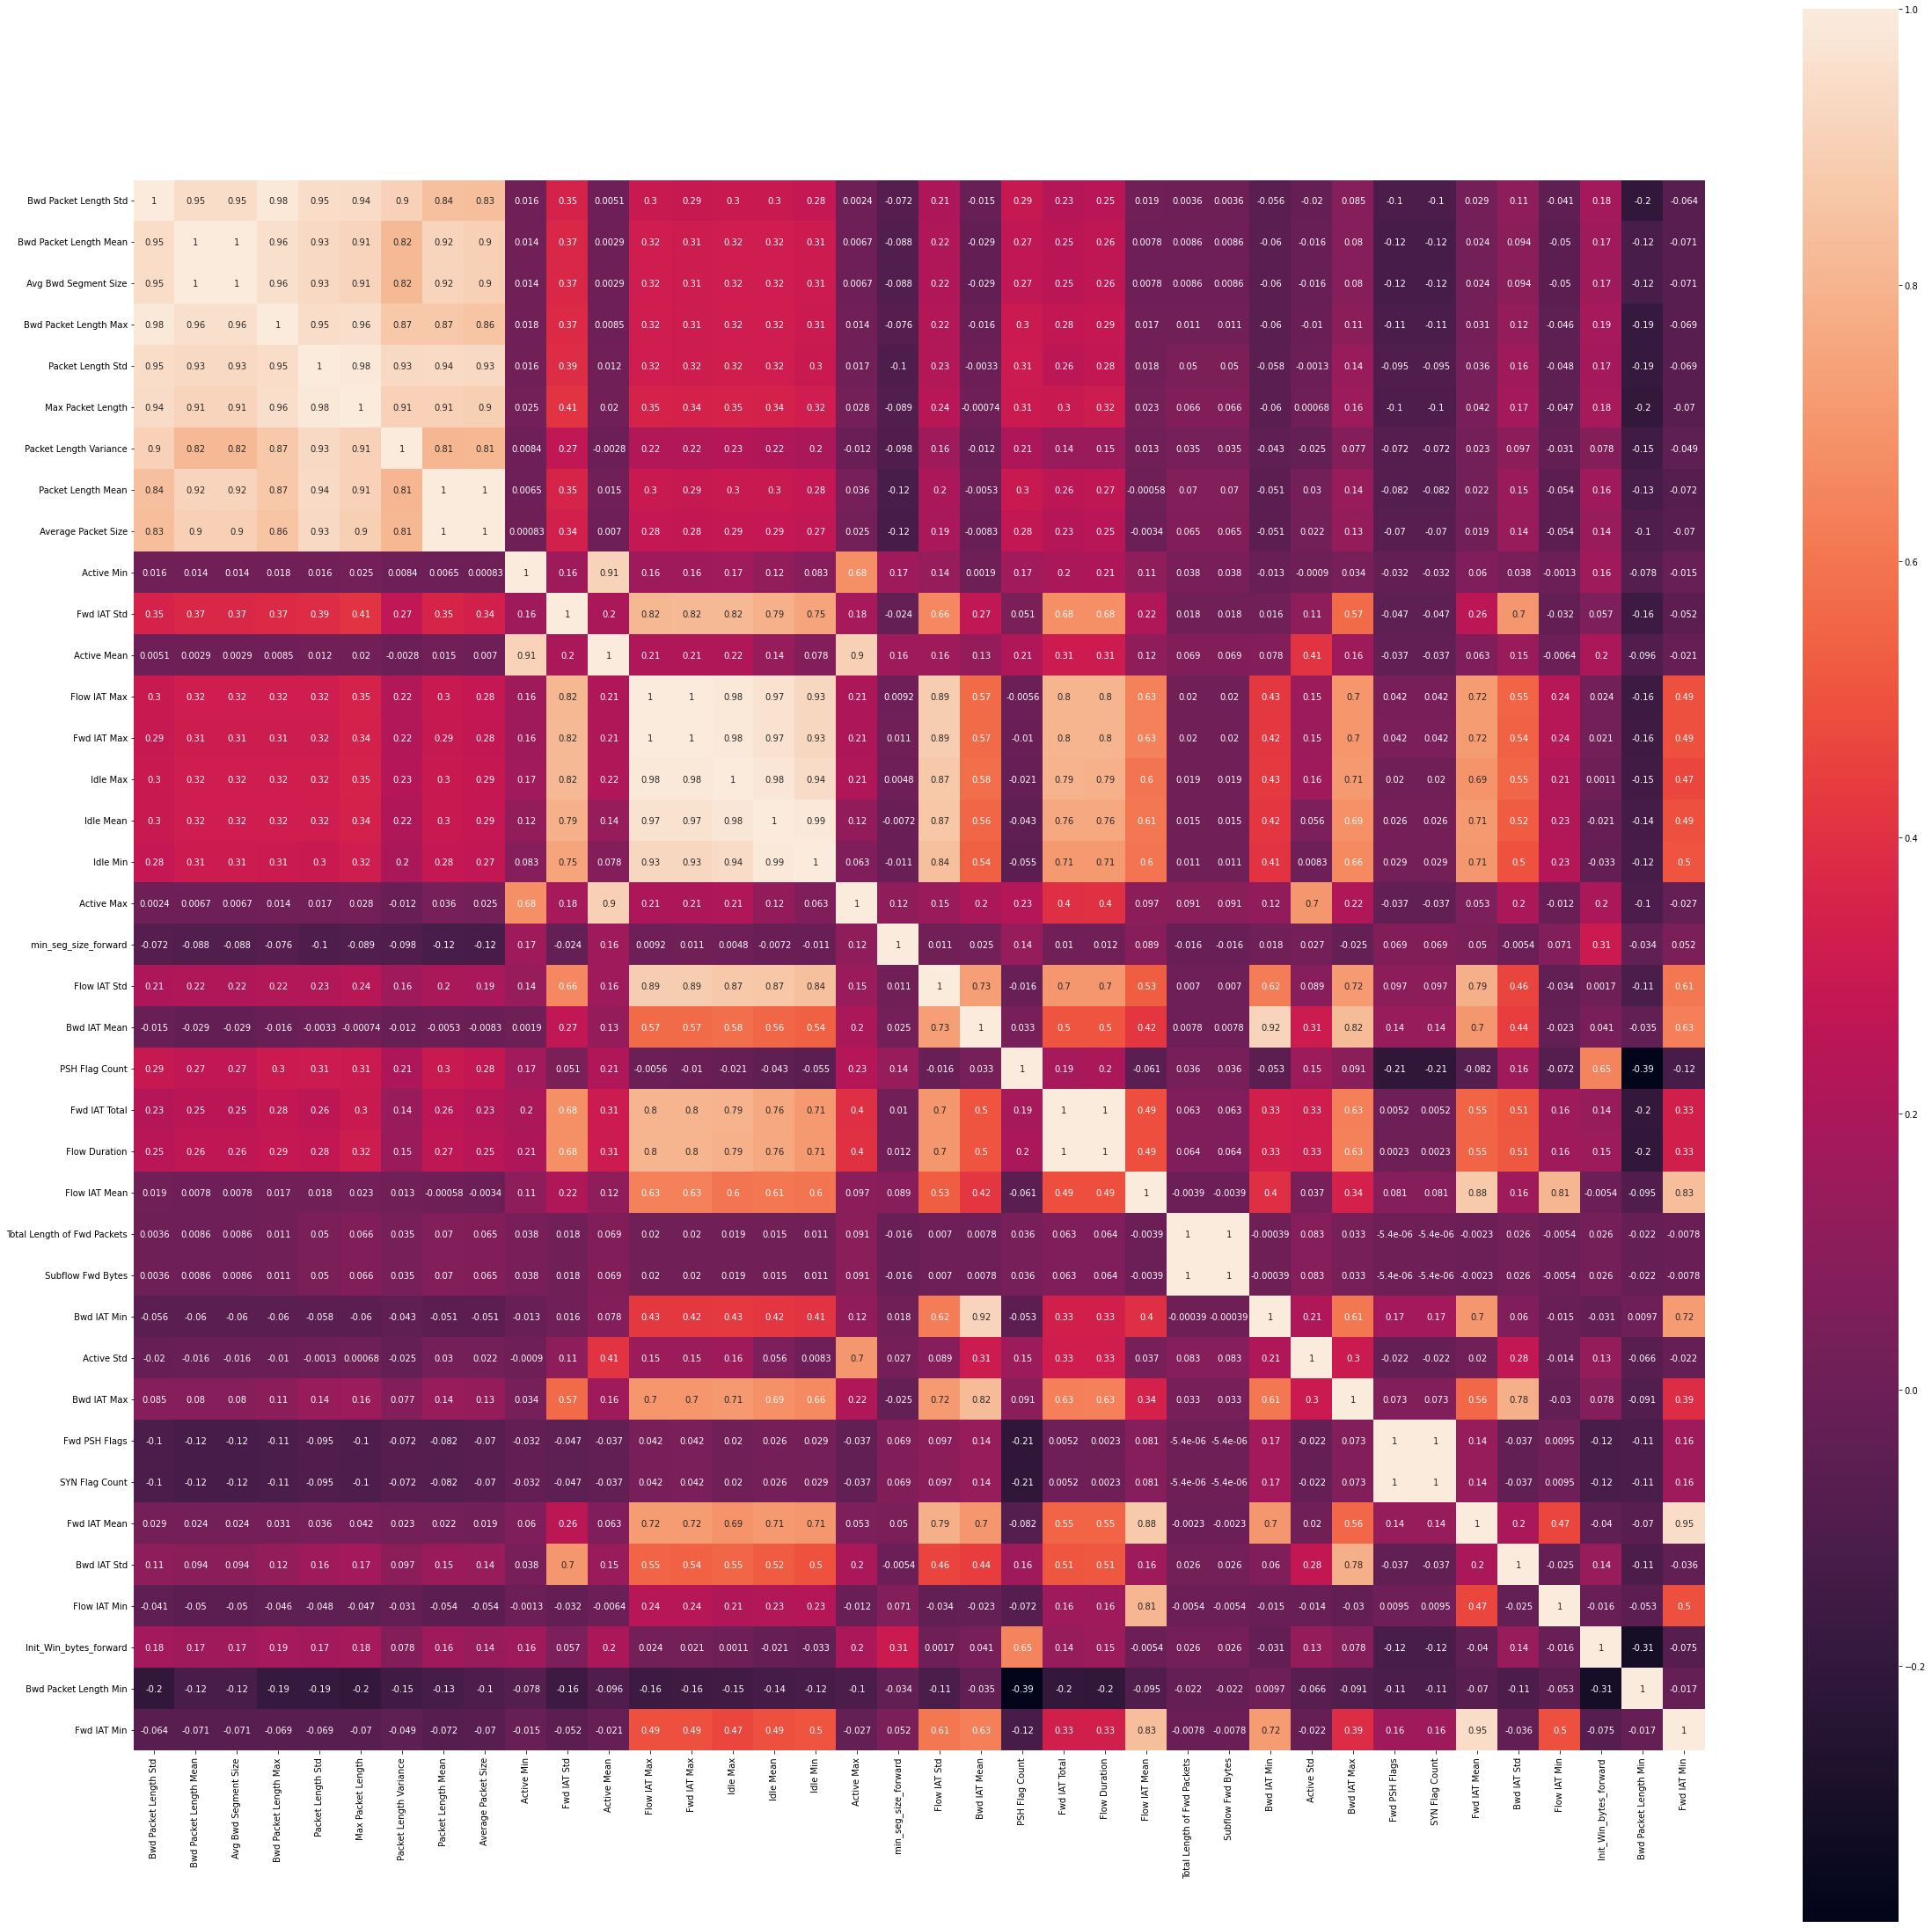

In [ ]:
fig= plt.figure(figsize=(40,40))
sns.heatmap(feature.corr(), annot=True, square=True)

Корреляция, статистический метод, который определяет, как одна переменная перемещается / изменяется по отношению к другой переменной. Когда у нас есть сильно коррелированные функции в наборе данных, это увеличивает дисперсию и ненадежность. Коррелеяция замечена с признаками:

* Total Length of Bwd Packets
* Subflow Bwd Bytes
* Fwd Header Length
* Fwd Header Length.1
* Bwd Header Length
* Total Fwd Packets
* Subflow Fwd Packets
* Bwd Packets Length Mean
* Avg Bwd Segment Size
* Packet Length Std
* Bwd Packet Length Max
* Bwd Packet Length Std
* Packet Length Mean
* Flow IAT Max
* Fwd IAT Max
* Fwd IAT Total
* Idle Max
* Flow Duration
* Idle Mean
* Idle Min


                

# 14. Исключение признаков для повышения качества датасета.

См. Тепловую карту

In [ ]:
#feature.drop(['Total Length of Bwd Packets'],axis=1,inplace=True)

In [ ]:
#feature.drop([' Subflow Bwd Bytes'],axis=1,inplace=True)

In [ ]:
#feature.drop([' Total Fwd Packets'],axis=1,inplace=True)

In [ ]:
#feature.drop(['Subflow Fwd Packets'],axis=1,inplace=True)

In [ ]:
feature.drop([' Bwd Packet Length Mean'],axis=1,inplace=True)

In [ ]:
feature.drop([' Avg Bwd Segment Size'],axis=1,inplace=True)

In [ ]:
feature.drop([' Packet Length Std'],axis=1,inplace=True)

In [ ]:
feature.drop(['Bwd Packet Length Max'],axis=1,inplace=True)

In [ ]:
feature.drop([' Bwd Packet Length Std'],axis=1,inplace=True)

In [ ]:
feature.drop([' Packet Length Mean'],axis=1,inplace=True)

In [ ]:
feature.drop([' Average Packet Size'],axis=1,inplace=True)

In [ ]:
feature.drop([' Max Packet Length'],axis=1,inplace=True)

In [ ]:
feature.drop([' Flow IAT Max'],axis=1,inplace=True)

In [ ]:
feature.drop([' Fwd IAT Max'],axis=1,inplace=True)

In [ ]:
feature.drop(['Fwd IAT Total'],axis=1,inplace=True)

In [ ]:
feature.drop([' Idle Max'],axis=1,inplace=True)

In [ ]:
feature.drop([' Flow Duration'],axis=1,inplace=True)

In [ ]:
feature.drop(['Idle Mean'],axis=1,inplace=True)

In [ ]:
feature.drop([' Idle Min'],axis=1,inplace=True)

# 15. Дополнительная проверка тепловой карты

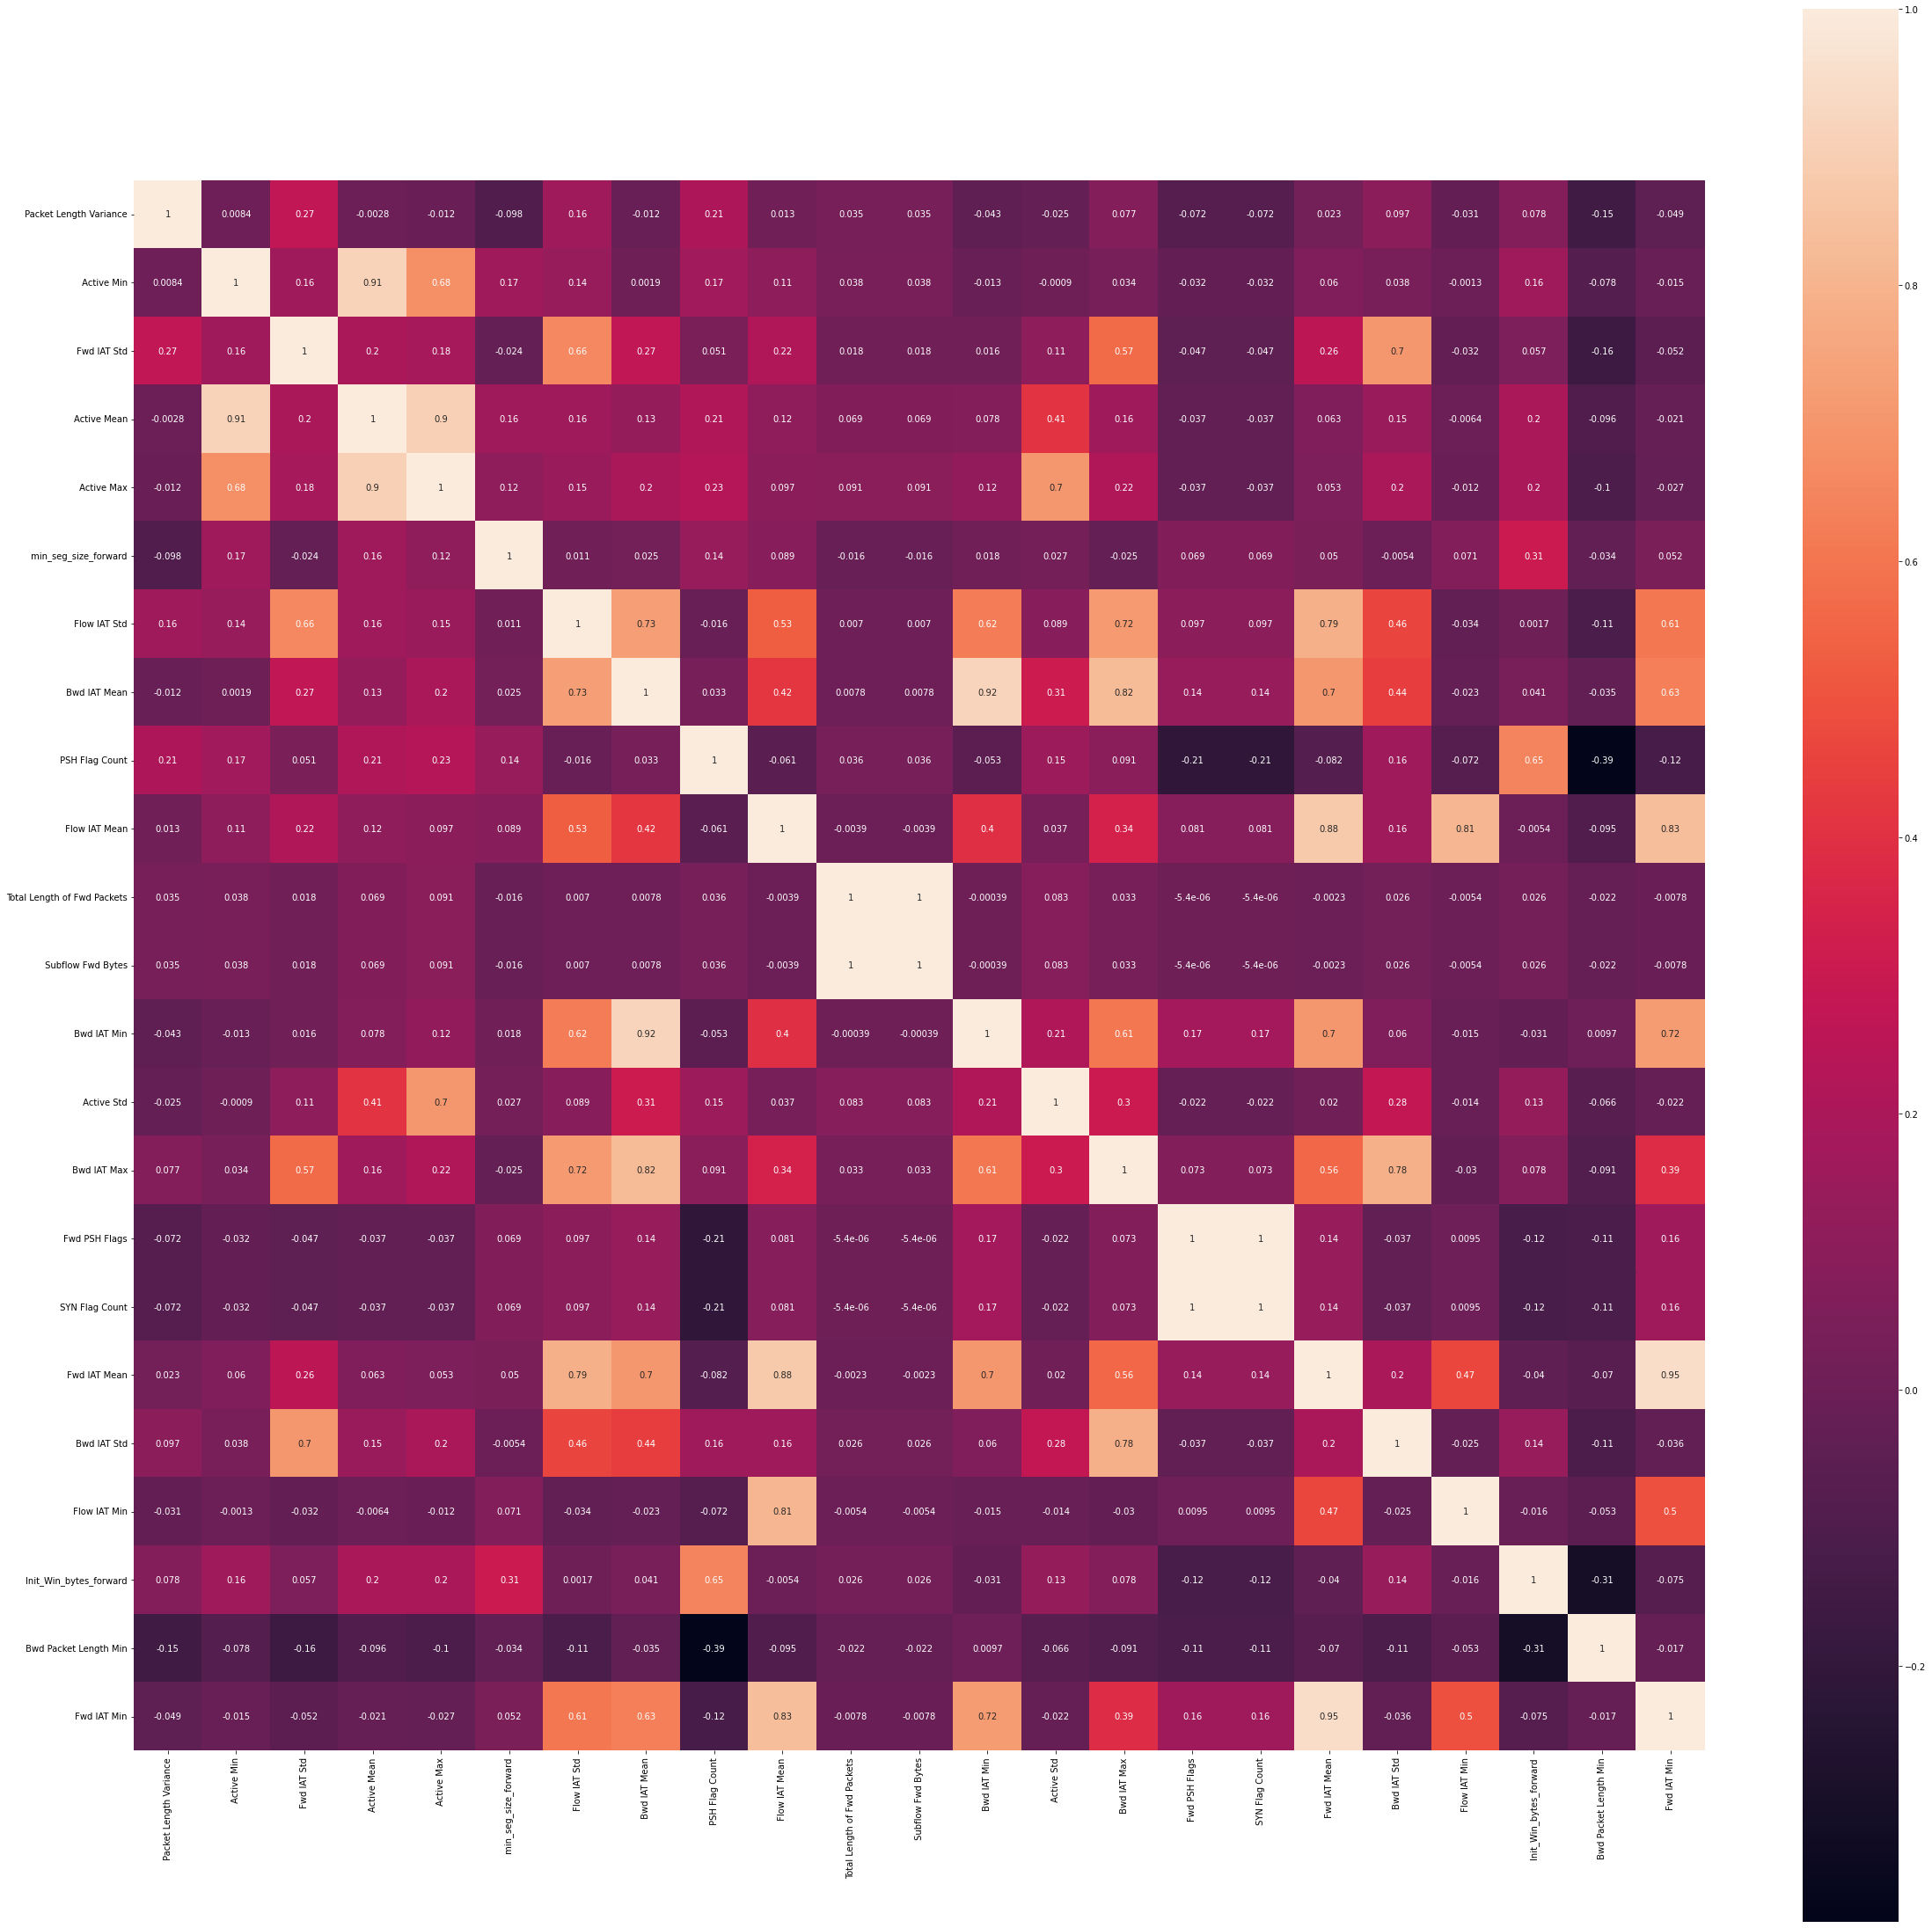

In [ ]:
fig= plt.figure(figsize=(40,40))
sns.heatmap(feature.corr(), annot=True, square=True)

# 16. Дополнительная проверка количества пакетов каждого типа

In [ ]:
feature[' Label'].value_counts()

BENIGN                        142069
DoS GoldenEye                  10293
DDoS                           10242
PortScan                        9536
DoS Hulk                        9243
FTP-Patator                     7938
SSH-Patator                     5897
DoS slowloris                   5796
DoS Slowhttptest                5499
Bot                             1966
Web Attack � Brute Force        1507
Web Attack � XSS                 652
Infiltration                      36
Web Attack � Sql Injection        21
Heartbleed                        11
Name:  Label, dtype: int64

In [ ]:
feature.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210706 entries, 24072 to 9242
Data columns (total 24 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0    Packet Length Variance      210706 non-null  float64
 1    Active Min                  210706 non-null  int32  
 2    Fwd IAT Std                 210706 non-null  float64
 3   Active Mean                  210706 non-null  float64
 4    Active Max                  210706 non-null  int32  
 5    min_seg_size_forward        210706 non-null  int16  
 6    Flow IAT Std                210706 non-null  float64
 7    Bwd IAT Mean                210706 non-null  float64
 8    PSH Flag Count              210706 non-null  int8   
 9    Flow IAT Mean               210706 non-null  float64
 10  Total Length of Fwd Packets  210706 non-null  int32  
 11   Subflow Fwd Bytes           210706 non-null  int32  
 12   Bwd IAT Min                 210706 non-null  int32  
 1

#**Замена маркировки уникального типа атаки на маркировку Attack (Не используется)**

In [ ]:
#feature[' Label'] = feature[' Label'].replace(to_replace =["FTP-Patator", "Heartbleed", "SSH-Patator", "Infiltration", "DoS GoldenEye", "Web Attack � Sql Injection", "Bot", "PortScan", "DoS Slowhttptest", "DoS slowloris", "DDoS", "DoS Hulk", "Web Attack � XSS", "Web Attack � Brute Force"], value ="ATTACK")

In [ ]:
#feature[' Label'].value_counts()

In [ ]:
#feature.head()

In [ ]:
#feature.info()

In [ ]:
#feature0 = feature[feature[' Label'] == 0]
#feature0.info()

Отбрасываем маркировки пакетов

In [ ]:
#y = feature[' Label']
#X = feature.drop([' Label'],axis=1)

# 17. Разделение датасетов для бинарной классификации

In [ ]:
feature0 = feature[feature[' Label'] == 0]
feature0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0    Packet Length Variance      0 non-null      float64
 1    Active Min                  0 non-null      int32  
 2    Fwd IAT Std                 0 non-null      float64
 3   Active Mean                  0 non-null      float64
 4    Active Max                  0 non-null      int32  
 5    min_seg_size_forward        0 non-null      int16  
 6    Flow IAT Std                0 non-null      float64
 7    Bwd IAT Mean                0 non-null      float64
 8    PSH Flag Count              0 non-null      int8   
 9    Flow IAT Mean               0 non-null      float64
 10  Total Length of Fwd Packets  0 non-null      int32  
 11   Subflow Fwd Bytes           0 non-null      int32  
 12   Bwd IAT Min                 0 non-null      int32  
 13   Active Std                  0 n

In [ ]:
feature_buyback = feature #backup feauture w/ benign

In [ ]:
feature = feature.set_index(' Label')
feature = feature.drop('BENIGN', axis = 0)
feature = feature.reset_index()
#feature.value_counts() #/проверка


#feature = feature.drop([feature[' Label'] == 'BENIGN'], axis = 0)
#feature = feature.drop(feature.index[feature[' Label'] == 'BENIGN'])

In [ ]:
feature_benign_only = feature_buyback.set_index(' Label')
feature_benign_only = feature_benign_only.drop(['FTP-Patator', 'Heartbleed', 'SSH-Patator', 'Infiltration', 'DoS GoldenEye', 'Web Attack � Sql Injection', 'Bot', 'PortScan', 'DoS Slowhttptest', 'DoS slowloris', 'DDoS', 'DoS Hulk', 'Web Attack � XSS', 'Web Attack � Brute Force'], axis=0)
feature_benign_only = feature_benign_only.reset_index()

#feature_benign_only = feature_buyback.drop(feature_buyback.index[feature_buyback[' Label'] != 'BENIGN'])
#feature_benign_only.info()
#'FTP-Patator', 'Heartbleed', 'SSH-Patator', 'Infiltration', 'DoS GoldenEye', 'Web Attack � Sql Injection', 'Bot', 'PortScan', 'DoS Slowhttptest', 'DoS slowloris', 'DDoS', 'DoS Hulk', 'Web Attack � XSS', 'Web Attack � Brute Force'

In [ ]:
y = feature[' Label']
X = feature.drop([' Label'],axis=1)

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

RandSamp = RandomUnderSampler('majority')
X_RandS, y_RandS = RandSamp.fit_resample(X, y)

/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:591: FutureWarning: Pass sampling_strategy=majority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning,


In [ ]:
X_RandS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58355 entries, 0 to 58354
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0    Packet Length Variance      58355 non-null  float64
 1    Active Min                  58355 non-null  int32  
 2    Fwd IAT Std                 58355 non-null  float64
 3   Active Mean                  58355 non-null  float64
 4    Active Max                  58355 non-null  int32  
 5    min_seg_size_forward        58355 non-null  int16  
 6    Flow IAT Std                58355 non-null  float64
 7    Bwd IAT Mean                58355 non-null  float64
 8    PSH Flag Count              58355 non-null  int8   
 9    Flow IAT Mean               58355 non-null  float64
 10  Total Length of Fwd Packets  58355 non-null  int32  
 11   Subflow Fwd Bytes           58355 non-null  int32  
 12   Bwd IAT Min                 58355 non-null  int32  
 13   Active Std     

In [ ]:
y_RandS.value_counts()

DDoS                          10242
PortScan                       9536
DoS Hulk                       9243
FTP-Patator                    7938
SSH-Patator                    5897
DoS slowloris                  5796
DoS Slowhttptest               5499
Bot                            1966
Web Attack � Brute Force       1507
Web Attack � XSS                652
Infiltration                     36
Web Attack � Sql Injection       21
DoS GoldenEye                    11
Heartbleed                       11
Name:  Label, dtype: int64

# 18 SMOTEtomek

In [ ]:
from imblearn.combine import SMOTETomek
smt = SMOTETomek('not majority' ,n_jobs=-1)
X_smt, y_smt = smt.fit_resample(X_RandS, y_RandS)

/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:591: FutureWarning: Pass sampling_strategy=not majority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning,


In [ ]:
y_smt.value_counts()

DoS GoldenEye                 10242
Heartbleed                    10242
Bot                           10241
Infiltration                  10241
PortScan                      10240
FTP-Patator                   10239
SSH-Patator                   10237
Web Attack � Sql Injection    10237
DoS Slowhttptest              10228
DoS slowloris                 10225
DoS Hulk                      10223
DDoS                          10222
Web Attack � Brute Force       9443
Web Attack � XSS               9442
Name:  Label, dtype: int64

In [ ]:
y_smt.head(6)

0    Bot
1    Bot
2    Bot
3    Bot
4    Bot
5    Bot
Name:  Label, dtype: object

In [ ]:
X_smt.head(5)

,Packet Length Variance,Active Min,Fwd IAT Std,Active Mean,Active Max,min_seg_size_forward,Flow IAT Std,Bwd IAT Mean,PSH Flag Count,Flow IAT Mean,Total Length of Fwd Packets,Subflow Fwd Bytes,Bwd IAT Min,Active Std,Bwd IAT Max,Fwd PSH Flags,SYN Flag Count,Fwd IAT Mean,Bwd IAT Std,Flow IAT Min,Init_Win_bytes_forward,Bwd Packet Length Min,Fwd IAT Min
0,8424.256836,50911,5.268490e+06,63678.199219,103175,32,4.901982e+06,7518953.5,1,3.541332e+06,322,322,637,22252.535156,10300000,0,0,6.396442e+06,4.645138e+06,47,29200,0,234
1,0.000000,0,0.000000e+00,0.000000,0,32,0.000000e+00,0.0,0,5.789100e+04,0,0,0,0.000000,0,0,0,0.000000e+00,0.000000e+00,57891,237,0,0
2,5668.285645,0,7.612682e+04,0.000000,0,20,5.323091e+04,66391.5,1,2.246867e+04,206,206,1660,0.000000,131123,0,0,4.493733e+04,9.154416e+04,123,8192,0,949
3,0.000000,0,0.000000e+00,0.000000,0,20,0.000000e+00,0.0,0,8.400000e+01,6,6,0,0.000000,0,0,0,0.000000e+00,0.000000e+00,84,237,6,0
4,5668.285645,0,7.217334e+04,0.000000,0,20,5.045570e+04,62993.5,1,2.129683e+04,206,206,1701,0.000000,124286,0,0,4.259367e+04,8.668069e+04,75,8192,0,745


In [ ]:
X_smt = X_smt.assign(label = y_smt)

In [ ]:
X_smt.head(5)

,Packet Length Variance,Active Min,Fwd IAT Std,Active Mean,Active Max,min_seg_size_forward,Flow IAT Std,Bwd IAT Mean,PSH Flag Count,Flow IAT Mean,Total Length of Fwd Packets,Subflow Fwd Bytes,Bwd IAT Min,Active Std,Bwd IAT Max,Fwd PSH Flags,SYN Flag Count,Fwd IAT Mean,Bwd IAT Std,Flow IAT Min,Init_Win_bytes_forward,Bwd Packet Length Min,Fwd IAT Min,label
0,8424.256836,50911,5.268490e+06,63678.199219,103175,32,4.901982e+06,7518953.5,1,3.541332e+06,322,322,637,22252.535156,10300000,0,0,6.396442e+06,4.645138e+06,47,29200,0,234,Bot
1,0.000000,0,0.000000e+00,0.000000,0,32,0.000000e+00,0.0,0,5.789100e+04,0,0,0,0.000000,0,0,0,0.000000e+00,0.000000e+00,57891,237,0,0,Bot
2,5668.285645,0,7.612682e+04,0.000000,0,20,5.323091e+04,66391.5,1,2.246867e+04,206,206,1660,0.000000,131123,0,0,4.493733e+04,9.154416e+04,123,8192,0,949,Bot
3,0.000000,0,0.000000e+00,0.000000,0,20,0.000000e+00,0.0,0,8.400000e+01,6,6,0,0.000000,0,0,0,0.000000e+00,0.000000e+00,84,237,6,0,Bot
4,5668.285645,0,7.217334e+04,0.000000,0,20,5.045570e+04,62993.5,1,2.129683e+04,206,206,1701,0.000000,124286,0,0,4.259367e+04,8.668069e+04,75,8192,0,745,Bot


# 19. Конкатенация датасетов

In [ ]:
feature_benign_only.head(1)

,Label,Packet Length Variance,Active Min,Fwd IAT Std,Active Mean,Active Max,min_seg_size_forward,Flow IAT Std,Bwd IAT Mean,PSH Flag Count,Flow IAT Mean,Total Length of Fwd Packets,Subflow Fwd Bytes,Bwd IAT Min,Active Std,Bwd IAT Max,Fwd PSH Flags,SYN Flag Count,Fwd IAT Mean,Bwd IAT Std,Flow IAT Min,Init_Win_bytes_forward,Bwd Packet Length Min,Fwd IAT Min
0,BENIGN,628951.375,0,1328264.75,0.0,0,32,775313.625,648934.6875,1,330113.65625,426,426,4,0.0,1945607,0,0,973144.0,1122951.375,4,29200,0,33919


In [ ]:
new_cols = [col for col in feature_benign_only.columns if col != ' Label'] + [' Label']
feature_benign_only = feature_benign_only[new_cols]
feature_benign_only.head(1)

,Packet Length Variance,Active Min,Fwd IAT Std,Active Mean,Active Max,min_seg_size_forward,Flow IAT Std,Bwd IAT Mean,PSH Flag Count,Flow IAT Mean,Total Length of Fwd Packets,Subflow Fwd Bytes,Bwd IAT Min,Active Std,Bwd IAT Max,Fwd PSH Flags,SYN Flag Count,Fwd IAT Mean,Bwd IAT Std,Flow IAT Min,Init_Win_bytes_forward,Bwd Packet Length Min,Fwd IAT Min,Label
0,628951.375,0,1328264.75,0.0,0,32,775313.625,648934.6875,1,330113.65625,426,426,4,0.0,1945607,0,0,973144.0,1122951.375,4,29200,0,33919,BENIGN


In [ ]:
feature_benign_only.rename(columns = {' Label':'label'}, inplace = True)

In [ ]:
dfs = [X_smt, feature_benign_only]
result = pd.concat(dfs)

In [ ]:
result.head(1)

,Packet Length Variance,Active Min,Fwd IAT Std,Active Mean,Active Max,min_seg_size_forward,Flow IAT Std,Bwd IAT Mean,PSH Flag Count,Flow IAT Mean,Total Length of Fwd Packets,Subflow Fwd Bytes,Bwd IAT Min,Active Std,Bwd IAT Max,Fwd PSH Flags,SYN Flag Count,Fwd IAT Mean,Bwd IAT Std,Flow IAT Min,Init_Win_bytes_forward,Bwd Packet Length Min,Fwd IAT Min,label
0,8424.256836,50911,5268490.0,63678.199219,103175,32,4901981.5,7518953.5,1,3541331.75,322,322,637,22252.535156,10300000,0,0,6396442.0,4645137.5,47,29200,0,234,Bot


# 20. Сохраним и разделим датасет на тестовую и тренировочную часть 

In [ ]:
result.to_csv('/content/drive/MyDrive/CICIDS2017/2022. Подключение к СИАСТ/x_smt.csv', index = False)

In [ ]:
#X_smt.to_csv('/content/drive/MyDrive/CICIDS2017/devtest/X_smt.csv')
#y_smt.to_csv('/content/drive/MyDrive/CICIDS2017/devtest/y_smt.csv')

# 21. Сохраним и разделим датасет на тестовую и тренировочную часть БЕЗ SMOTET

In [ ]:
#X = X.assign(label = y)
#X.to_csv('/content/drive/MyDrive/CICIDS2017/final master/X.csv', index = False)

# 22. Разделение датасета на тестовый и тренировочный

In [ ]:
#X_smt=pd.read_csv('/content/drive/MyDrive/CICIDS2017/devtest/X_smt.csv')
#y_smt=pd.read_csv('/content/drive/MyDrive/CICIDS2017/devtest/y_smt.csv')


#train_X,test_X,train_y,test_y=train_test_split(X_smt,y_smt,test_size=0.3, random_state=10)

#from numpy.random import RandomState
#rng = RandomState()

#train_X = X_smt.sample(frac=0.7, random_state=rng)
#test_X = X_smt.loc[~X_smt.index.isin(train_X.index)]

#train_y = y_smt.sample(frac=0.7, random_state=rng)
#test_y = y_smt.loc[~X_smt.index.isin(train_y.index)]

In [ ]:
file = pd.read_csv('/content/drive/MyDrive/CICIDS2017/2022. Подключение к СИАСТ/x_smt.csv')
file.info()

In [ ]:
!head -n 4000 '/content/drive/MyDrive/CICIDS2017/devtest/X_smt_test.csv'

Отделение части датасета для интеграции в машину

In [ ]:
#test_df = pd.read_csv('/content/drive/MyDrive/CICIDS2017/2022. Подключение к СИАСТ/x_smt.csv')
#train_x_smt, test_x_smt = train_test_split(test_df, test_size=0.2, random_state=10)
#test_x_smt.to_csv('/content/drive/MyDrive/CICIDS2017/2022. Подключение к СИАСТ/test_x_smt.csv', index = False)

# 24. Отделение "BENIGN" от всего датасета

Packet Length Variance      
Fwd IAT Std                 
Active Min                  
Active Mean                  
Active Max                    
Flow IAT Std                
Bwd IAT Mean                
PSH Flag Count                 
min_seg_size_forward         
Flow IAT Mean               
Active Std                  
Bwd IAT Min                  
Bwd IAT Max                   
Total Length of Fwd Packets    
Subflow Fwd Bytes            
Fwd PSH Flags                 
SYN Flag Count                
Fwd IAT Mean               
Bwd IAT Std                
Flow IAT Min                
Bwd Packet Length Min        
Init_Win_bytes_forward        
Fwd IAT Min        
Label

In [ ]:
data = []
target = []
file = pd.read_csv('/content/drive/MyDrive/CICIDS2017/2022. Подключение к СИАСТ/x_smt.csv')
for n, i in file.iterrows():
  a = []
  for j in i[:-1]:
    a.append(j)
  data.append(a)
  target.append(0 if i[-1] == 'BENIGN' else 1) #0 benign 1 attack
del file

In [ ]:
print('data example:')
print(data[:2])
print('target example:')
print(target[:2])

data example:
[[8424.2568359375, 50911, 5268490.0, 63678.19921875, 103175, 32, 4901981.5, 7518953.5, 1, 3541331.75, 322, 322, 637, 22252.53515625, 10300000, 0, 0, 6396442.0, 4645137.5, 47, 29200, 0, 234], [0.0, 0, 0.0, 0.0, 0, 32, 0.0, 0.0, 0, 57891.0, 0, 0, 0, 0.0, 0, 0, 0, 0.0, 0.0, 57891, 237, 0, 0]]
target example:
[1, 1]


Создание двух csv из target_df как набора 1 и 0 из верных маркировок и data_df как набора из признаков.

In [ ]:
target_df = pd.DataFrame(target)
csv_target_df = target_df.to_csv('/content/drive/MyDrive/CICIDS2017/2022. Подключение к СИАСТ/smt_y_bin.csv')
#data_df = pd.DataFrame(data)
#csv_data_df = data_df.to_csv('/content/drive/MyDrive/CICIDS2017/2022. Подключение к СИАСТ/smt_x_bin.csv')

In [ ]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(np.nan_to_num(data).astype(float))
data = scaler.transform(np.nan_to_num(data).astype(float))
print(data.shape)
#data = data.reshape(data.shape[0], 23)

(283771, 23)


In [ ]:
data_df = pd.DataFrame(data)
csv_data_df = data_df.to_csv('/content/drive/MyDrive/CICIDS2017/2022. Подключение к СИАСТ/smt_x_bin.csv')

# 25. Отделение бенигн (класс 0) и всех остальных как атаки

In [ ]:
data = np.array(data)
target = np.array(target)
print(data.shape, target.shape)
print('----')
print(data[0].shape)
print('----')
print(data[:2])
print('----')


(283771, 23) (283771,)
----
(23,)
----
[[-0.99924106 -0.99881464 -0.8720885  -0.99851739 -0.99791566 -0.91655802
  -0.88029349 -0.87468411  1.         -0.93601997 -0.99977531 -0.99977531
  -0.99998938 -0.99936421 -0.82833333 -1.         -1.         -0.89339263
  -0.88656563 -0.99999892 -0.1088562  -1.         -0.9999961 ]
 [-1.         -1.         -1.         -1.         -1.         -0.91655802
  -1.         -1.         -1.         -0.99895387 -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -0.99895387 -0.99273682 -1.         -1.        ]]
----


In [ ]:
#data_reshaped = data.reshape(data.shape[0], 1, data.shape[1])
#print(f"shape of data_reshaped:", data_reshaped.shape)
data = data.reshape(data.shape[0], data.shape[1], 1)
print(f"shape of data", data.shape)

shape of data (283771, 23, 1)


# 26. Моделирование бинарной нейросети LSTM.

In [ ]:
tf.keras.backend.clear_session()

#n_features = data_reshaped.shape[2]

lstm = Sequential()
lstm.add(Input((23, 1))) #lstm.add(Input((1, 23))) None - любое положительное целое число
lstm.add(LSTM(32, recurrent_activation='sigmoid', return_sequences=True, recurrent_dropout=0))
for i in range(4):
  lstm.add(LSTM(32, recurrent_activation='sigmoid', return_sequences=True, recurrent_dropout=0))
lstm.add(Flatten())
lstm.add(Dense(2 ,activation = 'softmax'))
lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 23, 32)            4352      
                                                                 
 lstm_1 (LSTM)               (None, 23, 32)            8320      
                                                                 
 lstm_2 (LSTM)               (None, 23, 32)            8320      
                                                                 
 lstm_3 (LSTM)               (None, 23, 32)            8320      
                                                                 
 lstm_4 (LSTM)               (None, 23, 32)            8320      
                                                                 
 flatten (Flatten)           (None, 736)               0         
                                                                 
 dense (Dense)               (None, 2)                 1

Тренировка нейросети

In [ ]:
lstm.fit(data, to_categorical(target), epochs=50, batch_size=256, verbose=1)

Epoch 1/50
 552/1109 [=============>................] - ETA: 1:03 - loss: 0.5865 - accuracy: 0.7086

In [ ]:
#lstm.save('/content/drive/MyDrive/CICIDS2017/2022. Подключение к СИАСТ/lstm.h5')
pickle.dump(lstm, open('/content/drive/MyDrive/CICIDS2017/2022. Подключение к СИАСТ/lstm.pkl', 'wb'))
#lstm = load_model('/content/drive/MyDrive/CICIDS2017/2022. Подключение к СИАСТ/lstm_fitted.h5')

Получение данных от нейросети

In [ ]:
y_pred1 = lstm.predict(data, batch_size=256)
y_pred = np.argmax(y_pred1, axis=1)

Вычисление метрик 

In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report
target_names = ['Benign', 'Attack']
print('==============================Classification Report=============================='.format(i))
print(classification_report(target, y_pred, target_names=target_names))
print('==============================Confussion Matrix and metrics=============================='.format(i))
tn, fp, fn, tp = confusion_matrix(target, y_pred).ravel()
sum = tn + fp + fn + tp
print('Confussion Matrix:', "\n", confusion_matrix(target, y_pred))
print("Accuracy: ", accuracy_score(target, y_pred))
recall = tp / (tp + fn)
print('recall:', recall)
precision = tp / (tp + fp)
print('precision:', precision)
print('f1 score:', 2 * (precision * recall) / (precision + recall))
print('ROC AUC:', roc_auc_score(target, y_pred))
unique, counts = np.unique(y_pred, return_counts=True)
count_list = dict(zip(unique, counts))
print('Alghorythm marked', count_list[1], 'as attack and', count_list[0], "packets as benign")

==============================Classification Report==============================
              precision    recall  f1-score   support

      Benign       0.86      0.89      0.88    142069
      Attack       0.89      0.86      0.87    141702

    accuracy                           0.87    283771
   macro avg       0.87      0.87      0.87    283771
weighted avg       0.87      0.87      0.87    283771

==============================Confussion Matrix and metrics==============================
Confussion Matrix: 
 [[126262  15807]
 [ 19865 121837]]
Accuracy:  0.8742930038657932
recall: 0.8598114352655573
precision: 0.8851602685187876
f1 score: 0.872301733334288
ROC AUC: 0.8742742990967152
Alghorythm marked 137644 as attack and 146127 packets as benign


# 27. Моделирование мультиклассовой нейросети KNN.


Чтение датасета для второй нейросети. 

In [14]:
data = []
target = []
types = []

file = pd.read_csv('/content/drive/MyDrive/CICIDS2017/2022. Подключение к СИАСТ/x_smt.csv')
for n, i in file.iterrows():
    if not i[-1] in types:
        types.append(i[-1])
    if types.index(i[-1]) != 0: #проверка бенингн или нет для записи в набор data 
      a = []
      for j in i[:-1]:
          a.append(j)
      data.append(a)
      target.append(types.index(i[-1])-1)
del file
del types[0]

In [4]:
df_x = pd.read_csv('/content/drive/MyDrive/CICIDS2017/2022. Подключение к СИАСТ/x_smt.csv')
#df_x.rename(columns={" Label": "label"}, inplace = True)
df_x = df_x[df_x.label != "BENIGN"] 
#df_x.to_csv('/content/drive/MyDrive/x_smt_no_benign', index=False)
#file = pd.read_csv('/content/drive/MyDrive/x_smt_no_benign')
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
target = le.fit_transform(df_x["label"])
data = df_x.drop("label", axis=1)

In [34]:
le.get_params(deep = True)
le.classes_

array(['Bot', 'DDoS', 'DoS GoldenEye', 'DoS Hulk', 'DoS Slowhttptest',
       'DoS slowloris', 'FTP-Patator', 'Heartbleed', 'Infiltration',
       'PortScan', 'SSH-Patator', 'Web Attack � Brute Force',
       'Web Attack � Sql Injection', 'Web Attack � XSS'], dtype=object)

Обработка

In [5]:
data = np.array(data)
target = np.array(target)
print(data.shape, target.shape)

(141702, 23) (141702,)


**Загрузка** нормализатора

In [6]:
scaler = pickle.load(open('/content/drive/MyDrive/CICIDS2017/devtest/scaler.pkl', 'rb'))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


Нормализация данных для второй нейросети

In [7]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(np.nan_to_num(data).astype(float))
data = scaler.transform(np.nan_to_num(data).astype(float))
print(data.shape)
data = data.reshape(data.shape[0], data.shape[1], 1)
print(data.shape)

(141702, 23)
(141702, 23, 1)


Моделирование мультиклассовой нейросети

In [8]:
tf.keras.backend.clear_session()

knn = Sequential()
knn.add(InputLayer((data.shape[1],)))
knn.add(BatchNormalization())
knn.add(Dense(128, activation='relu'))
knn.add(Dense(128, activation='relu'))
knn.add(Dense(14, activation='softmax'))
#optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
knn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
knn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 23)               92        
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               3072      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 14)                1806      
                                                                 
Total params: 21,482
Trainable params: 21,436
Non-trainable params: 46
_________________________________________________________________


Тренировка второй нейросети

In [ ]:
knn.fit(data.astype(float), target, epochs=50, batch_size=256, verbose=1)
#pickle.dump(knn, open('/content/drive/MyDrive/CICIDS2017/2022. Подключение к СИАСТ/knn.pkl', 'wb'))
#knn.save('/content/drive/MyDrive/CICIDS2017/devtest/knn.h5')

In [10]:
pickle.dump(knn, open('/content/drive/MyDrive/CICIDS2017/2022. Подключение к СИАСТ/knn.pkl', 'wb'))

Получение данных со второй нейросети

In [18]:
y_pred1 = knn.predict(data)
y_pred = np.argmax(y_pred1, axis=1)


{}


Вычисление метрик и количество классов

In [43]:
target_names = le.classes_
#target_names = ['Bot', 'DDoS', 'DoS GoldenEye', 'DoS Hulk', 'DoS Slowhttptest', 'DoS slowloris', 'FTP-Patator', 'Heartbleed', 'Infiltration', 'PortScan', 'SSH-Patator', 'Web Attack � Brute Force', 'Web Attack � Sql Injection', 'Web Attack � XSS']
print('==============================Classification Report==============================')
print(classification_report(target, y_pred, target_names=target_names))
print('==============================Confussion Matrix and metrics==============================')
print('recall:', recall_score(target, y_pred, average='micro'))
print('precision:', precision_score(target, y_pred, average='micro'))
print('accuracy:', accuracy_score(target, y_pred))
print('f1 score:', f1_score(target, y_pred, average='micro'))
print('ROC AUC:', roc_auc_score(to_categorical(target), np.nan_to_num(y_pred1), multi_class='ovr'))
print('Confussion Matrix:', "\n", confusion_matrix(target, y_pred))
unique, counts = np.unique(y_pred, return_counts=True)
count_list = dict(zip(unique, counts))

==============================Classification Report==============================
                            precision    recall  f1-score   support

                       Bot       1.00      1.00      1.00     10241
                      DDoS       1.00      0.97      0.99     10222
             DoS GoldenEye       1.00      1.00      1.00     10242
                  DoS Hulk       0.94      0.72      0.82     10223
          DoS Slowhttptest       0.98      0.97      0.98     10228
             DoS slowloris       0.96      0.87      0.91     10225
               FTP-Patator       0.91      0.99      0.95     10239
                Heartbleed       1.00      1.00      1.00     10242
              Infiltration       1.00      0.98      0.99     10241
                  PortScan       1.00      1.00      1.00     10240
               SSH-Patator       0.56      0.99      0.71     10237
  Web Attack � Brute Force       0.83      0.15      0.25      9443
Web Attack � Sql Injection       

In [29]:
print('recall:', recall_score(target, y_pred, average='micro'))
print('precision:', precision_score(target, y_pred, average='micro'))
print('accuracy:', accuracy_score(target, y_pred))
print('f1 score:', f1_score(target, y_pred, average='micro'))
print('ROC AUC:', roc_auc_score(to_categorical(target), np.nan_to_num(y_pred1), multi_class='ovr'))
print('матрица неточностей', confusion_matrix(target, y_pred))
unique, counts = np.unique(y_pred, return_counts=True)
count_list = dict(zip(unique, counts))
print('Классы:')
for i in count_list:
  if last[i] != "BENIGN":
    print(last[i], count_list[i]);

recall: 0.872105436332395
precision: 0.872105436332395
accuracy: 0.872105436332395
f1 score: 0.872105436332395
ROC AUC: 0.9909162934800683
матрица неточностей [[  9753      0    162      0      0      0      0      0      0      0
       0      0      0    307]
 [     0  10242      0      0      0      0      0      0      0      0
       0      0      0      0]
 [   245     15   6615      0      0      0      0      0      0      0
       0      0      0   3348]
 [     0      5      2   9240    331      0      0      0      0      0
       0      2      7    641]
 [     0      4      0    369   8302   1038      0      0      0      1
       0      2     12    497]
 [     0      0      0      0      0  10219      0      0      0      0
       0      0      1     19]
 [     0      0      1      0      0      0  10241      0      0      0
       0      0      0      0]
 [   102      0      0      0      0      0      0   9593      0      0
       0      0      0    546]
 [     0      0  

-

-

-

# 28. Проверка нейросети

Загрузка заранее обученной нейросети

In [ ]:
lstm = load_model('/content/drive/MyDrive/CICIDS2017/devtest/lstm.h5')
knn = load_model('/content/drive/MyDrive/CICIDS2017/devtest/knn.h5')

SystemError: ignored

Загрузка данных для тестирования нейросети

In [ ]:
file = pd.read_csv('/content/drive/MyDrive/CICIDS2017/data_analysis/Wednesday-workingHours.pcap_ISCX.csv')
data = []
target = []

for n, i in file.iterrows():
        a = []
        for j in i[:-1]:
          a.append(j)
        data.append(a)
        target.append(last.index(i[-1]))

Обработка данных

In [ ]:
data = np.array(data)
target = np.array(target)
data = data.reshape(data.shape[0], 78, 1)
print(data.shape, target.shape)

Проверка нейросети

In [ ]:
model.evaluate(data, target)

Предсказание нейросети

In [ ]:
pred = model.predict(data)

Определение класса предсказанния нейросети

In [ ]:
print(last[np.argmax(pred[5])])